# Определение стоимости автомобилей

Сервис по продаже автомобилей с пробегом «Не бит, не крашен» разрабатывает приложение для привлечения новых клиентов. В нём можно быстро узнать рыночную стоимость своего автомобиля. В вашем распоряжении исторические данные: технические характеристики, комплектации и цены автомобилей. Вам нужно построить модель для определения стоимости. 

Заказчику важны:

- качество предсказания;
- скорость предсказания;
- время обучения.

# Описание данных
1. Признаки:
- DateCrawled — дата скачивания анкеты из базы
- VehicleType — тип автомобильного кузова
- RegistrationYear — год регистрации автомобиля
- Gearbox — тип коробки передач
- Power — мощность (л. с.)
- Model — модель автомобиля
- Kilometer — пробег (км)
- RegistrationMonth — месяц регистрации автомобиля
- FuelType — тип топлива
- Brand — марка автомобиля
- Repaired — была машина в ремонте или нет
- DateCreated — дата создания анкеты
- NumberOfPictures — количество фотографий автомобиля
- PostalCode — почтовый индекс владельца анкеты (пользователя)
- LastSeen — дата последней активности пользователя

2. Целевой признак:
- Price — цена (евро)

# План работы
1. Загрузка данных
2. Изучение данных:
 - Заполнение пропущенных значений
 - Обработка аномалии в столбцах.
 - Удаление неинформативных данных.
3. Подготовка выборки для обучения моделей.
4. Обучение моделей, одна из которых — LightGBM, как минимум одна — не бустинг.
5. Анализ время обучения, время предсказания и качество моделей.
6. Выбор лучшей модели и проверка её качество на тестовой выборке.

## Подготовка данных

In [2]:
conda install -c conda-forge lightgbm

Solving environment: done


==> WARNING: A newer version of conda exists. <==
  current version: 4.13.0
  latest version: 23.1.0

Please update conda by running

    $ conda update -n base -c defaults conda



## Package Plan ##

  environment location: /Users/a1/opt/anaconda3

  added / updated specs:
    - lightgbm


The following packages will be downloaded:

    package                    |            build
    ---------------------------|-----------------
    conda-23.1.0               |   py39h6e9494a_0         908 KB  conda-forge
    lightgbm-3.1.1             |   py39h219cf5c_0        1022 KB  conda-forge
    python_abi-3.9             |           2_cp39           4 KB  conda-forge
    ruamel.yaml-0.17.21        |   py39ha30fb19_3         183 KB  conda-forge
    ruamel.yaml.clib-0.2.7     |   py39ha30fb19_1         118 KB  conda-forge
    ------------------------------------------------------------
                                           Total:         2.2 MB

The following 

In [3]:
# импорты сторонних библиотек
import pandas as pd
import lightgbm as lgb
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns

# импорты модулей текущего проекта
from sklearn.linear_model import (
    LinearRegression,
    Lasso
) 

from sklearn.metrics import mean_squared_error
from sklearn.model_selection import (
    cross_val_score,
    GridSearchCV,
    train_test_split
)

from sklearn.preprocessing import StandardScaler

%matplotlib inline

### Загрузка данных

In [4]:
try:
    data = pd.read_csv('/Users/a1/Documents/DataScientist/DataSets/autos.csv')
except:
    data = pd.read_csv("/datasets/autos.csv")

In [5]:
display(data.head())

,DateCrawled,Price,VehicleType,RegistrationYear,Gearbox,Power,Model,Kilometer,RegistrationMonth,FuelType,Brand,Repaired,DateCreated,NumberOfPictures,PostalCode,LastSeen
0,2016-03-24 11:52:17,480,NaN,1993,manual,0,golf,150000,0,petrol,volkswagen,NaN,2016-03-24 00:00:00,0,70435,2016-04-07 03:16:57
1,2016-03-24 10:58:45,18300,coupe,2011,manual,190,NaN,125000,5,gasoline,audi,yes,2016-03-24 00:00:00,0,66954,2016-04-07 01:46:50
2,2016-03-14 12:52:21,9800,suv,2004,auto,163,grand,125000,8,gasoline,jeep,NaN,2016-03-14 00:00:00,0,90480,2016-04-05 12:47:46
3,2016-03-17 16:54:04,1500,small,2001,manual,75,golf,150000,6,petrol,volkswagen,no,2016-03-17 00:00:00,0,91074,2016-03-17 17:40:17
4,2016-03-31 17:25:20,3600,small,2008,manual,69,fabia,90000,7,gasoline,skoda,no,2016-03-31 00:00:00,0,60437,2016-04-06 10:17:21


In [6]:
display(data.tail())

,DateCrawled,Price,VehicleType,RegistrationYear,Gearbox,Power,Model,Kilometer,RegistrationMonth,FuelType,Brand,Repaired,DateCreated,NumberOfPictures,PostalCode,LastSeen
354364,2016-03-21 09:50:58,0,NaN,2005,manual,0,colt,150000,7,petrol,mitsubishi,yes,2016-03-21 00:00:00,0,2694,2016-03-21 10:42:49
354365,2016-03-14 17:48:27,2200,NaN,2005,NaN,0,NaN,20000,1,NaN,sonstige_autos,NaN,2016-03-14 00:00:00,0,39576,2016-04-06 00:46:52
354366,2016-03-05 19:56:21,1199,convertible,2000,auto,101,fortwo,125000,3,petrol,smart,no,2016-03-05 00:00:00,0,26135,2016-03-11 18:17:12
354367,2016-03-19 18:57:12,9200,bus,1996,manual,102,transporter,150000,3,gasoline,volkswagen,no,2016-03-19 00:00:00,0,87439,2016-04-07 07:15:26
354368,2016-03-20 19:41:08,3400,wagon,2002,manual,100,golf,150000,6,gasoline,volkswagen,NaN,2016-03-20 00:00:00,0,40764,2016-03-24 12:45:21


In [7]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 354369 entries, 0 to 354368
Data columns (total 16 columns):
 #   Column             Non-Null Count   Dtype 
---  ------             --------------   ----- 
 0   DateCrawled        354369 non-null  object
 1   Price              354369 non-null  int64 
 2   VehicleType        316879 non-null  object
 3   RegistrationYear   354369 non-null  int64 
 4   Gearbox            334536 non-null  object
 5   Power              354369 non-null  int64 
 6   Model              334664 non-null  object
 7   Kilometer          354369 non-null  int64 
 8   RegistrationMonth  354369 non-null  int64 
 9   FuelType           321474 non-null  object
 10  Brand              354369 non-null  object
 11  Repaired           283215 non-null  object
 12  DateCreated        354369 non-null  object
 13  NumberOfPictures   354369 non-null  int64 
 14  PostalCode         354369 non-null  int64 
 15  LastSeen           354369 non-null  object
dtypes: int64(7), object(

In [8]:
data.describe()

,Price,RegistrationYear,Power,Kilometer,RegistrationMonth,NumberOfPictures,PostalCode
count,354369.000000,354369.000000,354369.000000,354369.000000,354369.000000,354369.0,354369.000000
mean,4416.656776,2004.234448,110.094337,128211.172535,5.714645,0.0,50508.689087
std,4514.158514,90.227958,189.850405,37905.341530,3.726421,0.0,25783.096248
min,0.000000,1000.000000,0.000000,5000.000000,0.000000,0.0,1067.000000
25%,1050.000000,1999.000000,69.000000,125000.000000,3.000000,0.0,30165.000000
50%,2700.000000,2003.000000,105.000000,150000.000000,6.000000,0.0,49413.000000
75%,6400.000000,2008.000000,143.000000,150000.000000,9.000000,0.0,71083.000000
max,20000.000000,9999.000000,20000.000000,150000.000000,12.000000,0.0,99998.000000


Удалим не информативные столбцы:
- 'DateCrawled' дата скачивания анкеты не влияет на цену,
- 'RegistrationMonth' на вряд ли влияте на цену,
- 'NumberOfPictures' количестов фотографий не оказывает влияние на цену, 
- 'PostalCode' почтовый индекс владельца не оказывает влияние на цену.

In [9]:
data = data.drop([
    'DateCrawled',
    'RegistrationMonth',
    'NumberOfPictures',
    'PostalCode'], axis=1)

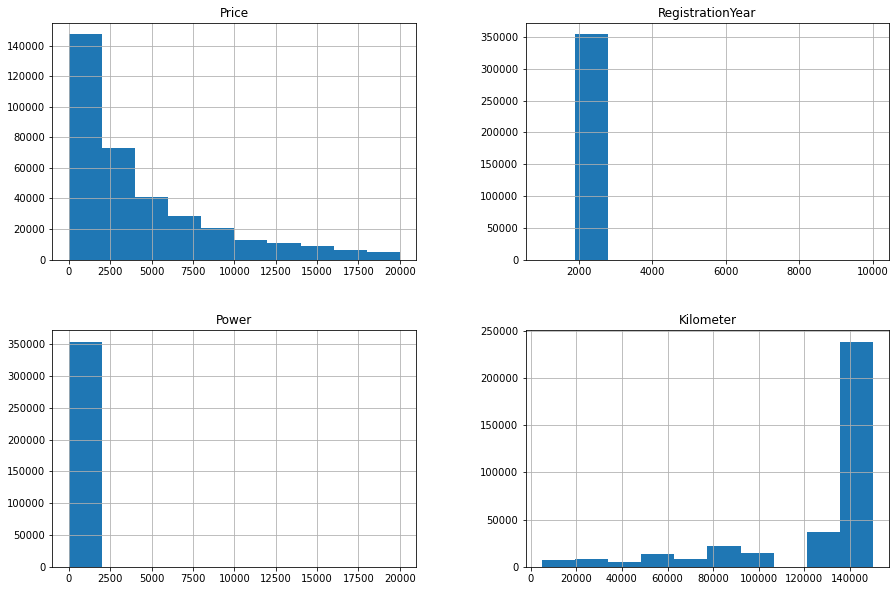

In [10]:
data.hist(figsize=(15, 10));

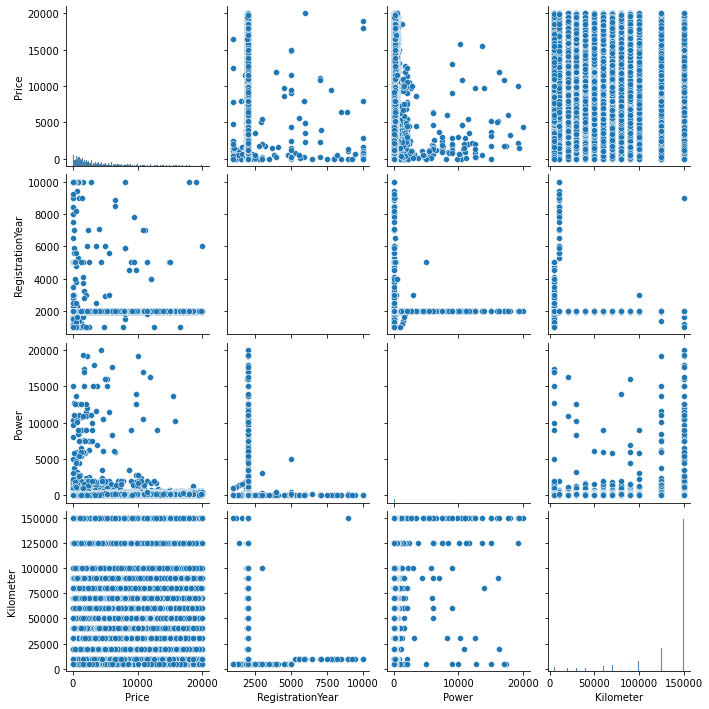

In [11]:
sns.pairplot(data)

В датасете две группу признаков:
1. Категориальные:
    - VehicleType — тип автомобильного кузова 
    - Gearbox — тип коробки передач
    - Model — модель автомобиля
    - FuelType — тип топлива
    - Brand — марка автомобиля
    - Repaired — была машина в ремонте или нет
2. Числовые:
    - RegistrationYear — год регистрации автомобиля
    - Power — мощность (л. с.)
    - Kilometer — пробег (км)
    - DateCreated — дата создания анкет
    - LastSeen — дата последней активности пользователя
    
    
- Price — цена (евро). Явлеятся целевым признаком

### Предобработка данных

#### Работа спропусками по всем признакам

In [12]:
data.isna().sum()

Price                   0
VehicleType         37490
RegistrationYear        0
Gearbox             19833
Power                   0
Model               19705
Kilometer               0
FuelType            32895
Brand                   0
Repaired            71154
DateCreated             0
LastSeen                0
dtype: int64

In [13]:
# check
# пропущенные значения бары
def pass_value_barh(df):
    try:
        (
            (df.isna().mean()*100)
            .to_frame()
            .rename(columns = {0:'space'})
            .query('space > 0')
            .sort_values(by = 'space', ascending = True)
            .plot(kind= 'barh', figsize=(19,6), rot = -5, legend = False, fontsize = 16)
            .set_title('Пропуски' + "\n", fontsize = 22, color = 'SteelBlue')    
        );    
    except:
        print('Пропусков не осталось')

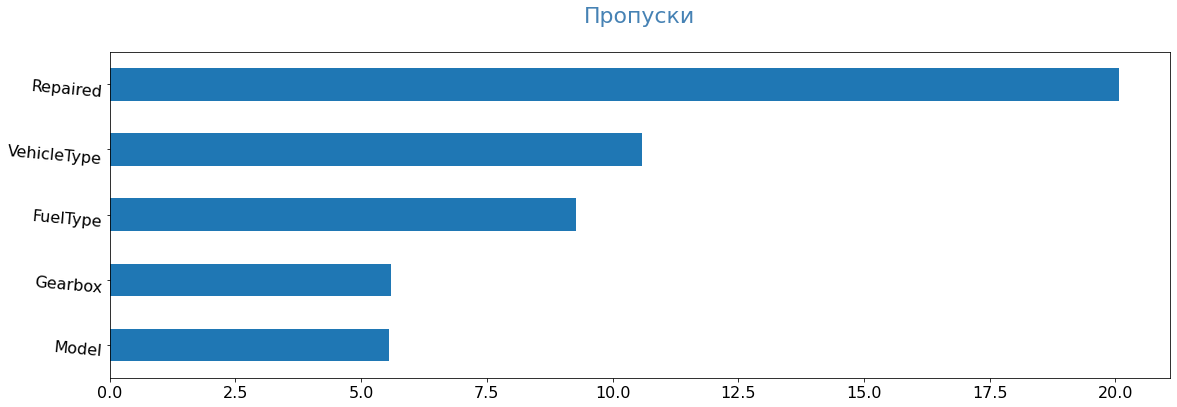

In [14]:
pass_value_barh(data)

- Признак 'Repaired': Данные признак категориальный. Поскольку нет инофрмации постаим заглушку 'unknown'.

In [15]:
data['Repaired']=data['Repaired'].fillna(value ='unknown')

- Признак 'Model':
    Данный признак является основным. Нет возможности восатновить его. Придется удалить строки с пропусками. Количетсов удалякемых строк 5,4%.

In [16]:
data = data.loc[~data['Model'].isna()]

- Признак 'VehicleType': предположим, что данный параметр одинаков в одинаковых моделях автомобилей, соответсвенно заполним пропуски  наиболее частым значением для одной и той же модели.

In [17]:
data['VehicleType'] = data['VehicleType'].fillna(data
                                                 .groupby('Model')['VehicleType']
                                                 .transform(lambda x: x.value_counts().idxmax()))

/var/folders/93/bhstkg4d6gx8wwcqf54nfpnr0000gn/T/ipykernel_63562/241275826.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['VehicleType'] = data['VehicleType'].fillna(data


- Признак 'FuelType': предположим, что данный параметр одинаков в одинаковых моделях автомобилей, соответсвенно заполним пропуски  наиболее частым значением для одной и той же модели

In [18]:
data['FuelType'] = data['FuelType'].fillna(data
                                           .groupby('Model')['FuelType']
                                           .transform(lambda x: x.value_counts().idxmax()))

/var/folders/93/bhstkg4d6gx8wwcqf54nfpnr0000gn/T/ipykernel_63562/3310198856.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['FuelType'] = data['FuelType'].fillna(data


- Признак 'Gearbox': предположим, что данный параметр одинаков в одинаковых моделях автомобилей, соответсвенно заполним пропуски  наиболее частым значением для одной и той же модели

In [19]:
data['Gearbox'] = data['Gearbox'].fillna(data
                                         .groupby('Model')['Gearbox']
                                         .transform(lambda x: x.value_counts().idxmax()))

/var/folders/93/bhstkg4d6gx8wwcqf54nfpnr0000gn/T/ipykernel_63562/966288150.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Gearbox'] = data['Gearbox'].fillna(data


In [20]:
data.isna().sum()

Price               0
VehicleType         0
RegistrationYear    0
Gearbox             0
Power               0
Model               0
Kilometer           0
FuelType            0
Brand               0
Repaired            0
DateCreated         0
LastSeen            0
dtype: int64

#### Удаление дубликатов

In [21]:
data.duplicated().value_counts()

False    334549
True        115
dtype: int64

Дубликатов не много, и все же удалим их.

In [22]:
# удаление дубликатов
data = data.drop_duplicates()

#### Обработка и удаление аномалий

- Признак 'Price':

In [23]:
(data[['Price']].apply (['count', 'min', 'mean','max']).style.format("{:,.2f}"))

,Price
count,"334,549.00"
min,0.00
mean,"4,504.01"
max,"20,000.00"


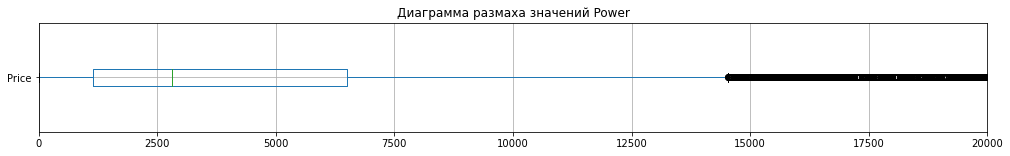

In [24]:
fig, ax = plt.subplots(figsize = (17,2))
ax = data[['Price']].boxplot(vert = False, ax =ax)
ax.set_title('Диаграмма размаха значений Power')
ax.set_xlim(0, 20000);

Цена не может быть 0. Если стоит цена 0 значит ее забыли поставить. Цена является целевым признаком. Строки с нулевой ценой необходимо удалить, така как востановаить их не получится.

In [25]:
print("Количество объявлений с нулевой ценой подлежащих удалению:", len(data.loc[data['Price'] == 0]))

Количество объявлений с нулевой ценой подлежащих удалению: 8587


In [26]:
#удалим данные с нулевой ценой
data = data.loc[data['Price'] != 0]

- Признак 'Power':

In [27]:
(data[['Power']].apply (['count', 'min', 'mean','max']).style.format("{:,.2f}"))

,Power
count,"325,962.00"
min,0.00
mean,111.98
max,"20,000.00"


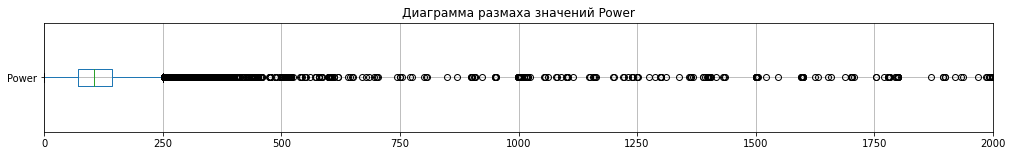

In [28]:
fig, ax = plt.subplots(figsize = (17,2))
ax = data[['Power']].boxplot(vert = False, ax =ax)
ax.set_title('Диаграмма размаха значений Power')
ax.set_xlim(0, 2000);

Из графика выше видно, что есть машины с 0 мощностью и с очень большой мощностью, больше 750 л.с. Удалим их.

In [29]:
print("Количество объявлений с 0 мощностью подлежащих удалению:", len(data.loc[data['Power'] == 0]))
print("Количество объявлений с аномальной мощностью подлежащих удалению:", len(data.loc[data['Power'] > 750]))

Количество объявлений с 0 мощностью подлежащих удалению: 31331
Количество объявлений с аномальной мощностью подлежащих удалению: 285


Заменим медианнным значеним мощности для соответсующей модели.

In [30]:
#обнулим мощности больше 750 л.с, а также отрицательные если таковые бы имелись.
data.loc[(data['Power'] > 750) | (data['Power'] <= 0), 'Power'] = None
#заполним медианой
data['Power'] = data['Power'].fillna(data.groupby('Model')['Power'].transform('median'))
data = data.loc[~data['Power'].isna()]
# изменим тим на 'int64'
data['Power'] = data['Power'].astype('int64')

- Признак 'RegistrationYear':

Рассмотрим, есть ли в таблице данные с неправильной регистрацией. 

In [31]:
(data[['RegistrationYear']].apply (['count', 'min', 'mean','max']).style.format("{:,.2f}"))

,RegistrationYear
count,"325,961.00"
min,"1,000.00"
mean,"2,003.95"
max,"9,999.00"


Определим верхнюю границу дату регистрации, через дату публикации анкеты. Дата регистрации не может быть больше даты публикации анкеты

In [32]:
print(max(data['DateCreated']))

2016-04-07 00:00:00


Максимальная дата регистарции автомобиля не может быть больше 2016 года

In [33]:
max_date_reg =pd.Timestamp(max(data['DateCreated'])).year
#check
print(max_date_reg)

2016


Минимальную дата регистрации атомобиля примим не ранее 1900 года.

In [34]:
min_date_reg = 1900

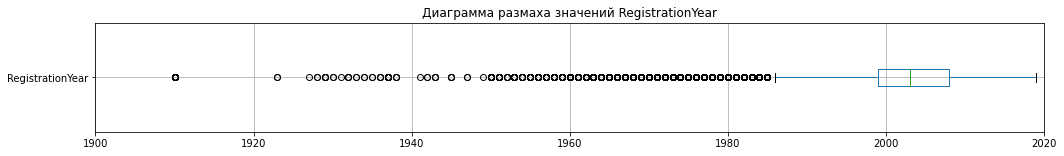

In [35]:
fig, ax = plt.subplots(figsize = (17,2))
ax = data[['RegistrationYear']].boxplot(vert = False, ax =ax)
ax.set_title('Диаграмма размаха значений RegistrationYear')
ax.set_xlim(min_date_reg, max_date_reg+4);

In [36]:
print("Количество объявлений с аномальной высокой регистрацией для удаления:", len(
    data.loc[data['RegistrationYear'] > max_date_reg]))
print("Количество объявлений с аномальной низкой регистрацией для удаления:", len(
    data.loc[data['RegistrationYear'] < min_date_reg]))

Количество объявлений с аномальной высокой регистрацией для удаления: 11920
Количество объявлений с аномальной низкой регистрацией для удаления: 28


In [37]:
data.loc[data['RegistrationYear'] > max_date_reg].head()

,Price,VehicleType,RegistrationYear,Gearbox,Power,Model,Kilometer,FuelType,Brand,Repaired,DateCreated,LastSeen
22,2900,bus,2018,manual,90,meriva,150000,petrol,opel,no,2016-03-23 00:00:00,2016-03-31 01:16:33
26,5555,sedan,2017,manual,125,c4,125000,gasoline,citroen,no,2016-03-10 00:00:00,2016-03-16 09:16:46
48,7750,sedan,2017,manual,80,golf,100000,petrol,volkswagen,unknown,2016-03-25 00:00:00,2016-03-31 21:47:44
51,2000,small,2017,manual,90,punto,150000,gasoline,fiat,yes,2016-03-07 00:00:00,2016-03-07 18:57:08
57,2399,sedan,2018,manual,64,other,125000,petrol,seat,no,2016-03-10 00:00:00,2016-03-25 10:17:37


In [38]:
data.loc[data['RegistrationYear'] < min_date_reg].head()

,Price,VehicleType,RegistrationYear,Gearbox,Power,Model,Kilometer,FuelType,Brand,Repaired,DateCreated,LastSeen
16062,190,wagon,1000,manual,131,mondeo,5000,petrol,ford,unknown,2016-03-29 00:00:00,2016-04-06 10:44:58
18224,7999,sedan,1500,manual,224,impreza,5000,petrol,subaru,unknown,2016-03-09 00:00:00,2016-03-15 05:15:17
53577,330,small,1000,manual,60,polo,5000,petrol,volkswagen,unknown,2016-03-20 00:00:00,2016-04-04 08:17:15
56241,950,sedan,1400,manual,101,golf,125000,petrol,volkswagen,unknown,2016-03-30 00:00:00,2016-04-03 09:45:19
71459,500,sedan,1000,manual,101,golf,5000,petrol,volkswagen,unknown,2016-03-27 00:00:00,2016-03-29 13:46:49


Удалим строки с неправлиьной регистрацией

In [39]:
data = data.loc[data['RegistrationYear'] <= max_date_reg]
data = data.loc[data['RegistrationYear'] >  min_date_reg] 

- Признак DateCreated:

In [40]:
# выведем самую раннюю дату пабликации
first_date = min(data['DateCreated'])
print(first_date)

2014-03-10 00:00:00


Приеобразуем все даты в числовой и выразим его в количестве дней от первоначальной даты

In [41]:
start_date = pd.Timestamp(first_date)
data['DateCreated'] = data['DateCreated'].map(lambda date : (pd.Timestamp(date) - start_date).days)

- Признак LastSeen:

Приеобразуем все даты в числовой формат и выразим его в количестве дней от первоначальной даты

In [42]:
data['LastSeen'] = data['LastSeen'].map(lambda date : (pd.Timestamp(date) - start_date).days)

- Признак 'Brand':

In [43]:
data['Brand'].value_counts()

volkswagen       68049
opel             35183
bmw              33246
mercedes_benz    29380
audi             26669
ford             22672
renault          15810
peugeot           9697
fiat              8456
seat              6171
skoda             5188
mazda             4975
smart             4754
citroen           4605
nissan            4449
toyota            4268
hyundai           3226
mini              3017
volvo             2969
mitsubishi        2685
honda             2474
kia               2209
suzuki            2086
alfa_romeo        2049
chevrolet         1569
chrysler          1255
dacia              847
daihatsu           717
porsche            689
subaru             685
jeep               614
land_rover         514
saab               489
jaguar             478
daewoo             465
trabant            419
lancia             415
rover              374
lada               196
Name: Brand, dtype: int64

In [44]:
print(len(data['Brand'].unique()))
print(data['Brand'].unique())

39
['volkswagen' 'jeep' 'skoda' 'bmw' 'peugeot' 'ford' 'mazda' 'nissan'
 'renault' 'mercedes_benz' 'seat' 'honda' 'fiat' 'opel' 'mini' 'smart'
 'hyundai' 'audi' 'alfa_romeo' 'subaru' 'volvo' 'mitsubishi' 'kia'
 'suzuki' 'lancia' 'citroen' 'toyota' 'chevrolet' 'dacia' 'daihatsu'
 'chrysler' 'jaguar' 'daewoo' 'porsche' 'rover' 'saab' 'land_rover'
 'trabant' 'lada']


- Признак 'Model':

In [45]:
print(len(data['Model'].unique()))

249


In [46]:
data['Model'].unique()

array(['golf', 'grand', 'fabia', '3er', '2_reihe', 'c_max', '3_reihe',
       'passat', 'navara', 'ka', 'polo', 'twingo', 'a_klasse', 'scirocco',
       '5er', 'arosa', 'other', 'civic', 'transporter', 'punto',
       'e_klasse', 'clio', 'kadett', 'kangoo', 'one', 'fortwo', '1er',
       'b_klasse', 'signum', 'astra', 'a8', 'jetta', 'fiesta', 'c_klasse',
       'micra', 'vito', 'sprinter', '156', 'escort', 'forester',
       'xc_reihe', 'scenic', 'a4', 'a1', 'insignia', 'combo', 'focus',
       'tt', 'corsa', 'a6', 'jazz', 'omega', 'slk', '7er', '80', '147',
       '100', 'z_reihe', 'sorento', 'v40', 'ibiza', 'mustang', 'eos',
       'touran', 'getz', 'a3', 'almera', 'megane', 'lupo', 'r19', 'caddy',
       'mondeo', 'cordoba', 'colt', 'impreza', 'vectra', 'berlingo',
       'tiguan', 'sharan', '6_reihe', 'c4', 'panda', 'up', 'i_reihe',
       'ceed', '5_reihe', 'yeti', 'octavia', 'zafira', 'mii', 'rx_reihe',
       '6er', 'modus', 'fox', 'matiz', 'beetle', 'c1', 'rio', 'touareg',
    

Промежуточное замечание: Из приведенных выше категориальных значений признаков 'Model' и 'Brand' видно, что их очень много. На следующем этапе нужно будет их закодировать

Посмотрим на полученный результат

In [47]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 314013 entries, 0 to 354368
Data columns (total 12 columns):
 #   Column            Non-Null Count   Dtype 
---  ------            --------------   ----- 
 0   Price             314013 non-null  int64 
 1   VehicleType       314013 non-null  object
 2   RegistrationYear  314013 non-null  int64 
 3   Gearbox           314013 non-null  object
 4   Power             314013 non-null  int64 
 5   Model             314013 non-null  object
 6   Kilometer         314013 non-null  int64 
 7   FuelType          314013 non-null  object
 8   Brand             314013 non-null  object
 9   Repaired          314013 non-null  object
 10  DateCreated       314013 non-null  int64 
 11  LastSeen          314013 non-null  int64 
dtypes: int64(6), object(6)
memory usage: 31.1+ MB


In [48]:
data.head()

,Price,VehicleType,RegistrationYear,Gearbox,Power,Model,Kilometer,FuelType,Brand,Repaired,DateCreated,LastSeen
0,480,sedan,1993,manual,101,golf,150000,petrol,volkswagen,unknown,745,759
2,9800,suv,2004,auto,163,grand,125000,gasoline,jeep,unknown,735,757
3,1500,small,2001,manual,75,golf,150000,petrol,volkswagen,no,738,738
4,3600,small,2008,manual,69,fabia,90000,gasoline,skoda,no,752,758
5,650,sedan,1995,manual,102,3er,150000,petrol,bmw,yes,756,758


In [49]:
data.tail()

,Price,VehicleType,RegistrationYear,Gearbox,Power,Model,Kilometer,FuelType,Brand,Repaired,DateCreated,LastSeen
354362,3200,sedan,2004,manual,225,leon,150000,petrol,seat,yes,740,740
354363,1150,bus,2000,manual,125,zafira,150000,petrol,opel,no,748,750
354366,1199,convertible,2000,auto,101,fortwo,125000,petrol,smart,no,726,732
354367,9200,bus,1996,manual,102,transporter,150000,gasoline,volkswagen,no,740,759
354368,3400,wagon,2002,manual,100,golf,150000,gasoline,volkswagen,unknown,741,745


Проверим дата сет на наличие кореляции

In [50]:
data.corr()

,Price,RegistrationYear,Power,Kilometer,DateCreated,LastSeen
Price,1.000000,0.470781,0.500758,-0.367640,0.011577,0.150173
RegistrationYear,0.470781,1.000000,0.131531,-0.259255,-0.002825,0.023695
Power,0.500758,0.131531,1.000000,0.101279,-0.000121,0.051172
Kilometer,-0.367640,-0.259255,0.101279,1.000000,0.000457,-0.067936
DateCreated,0.011577,-0.002825,-0.000121,0.000457,1.000000,0.562364
LastSeen,0.150173,0.023695,0.051172,-0.067936,0.562364,1.000000


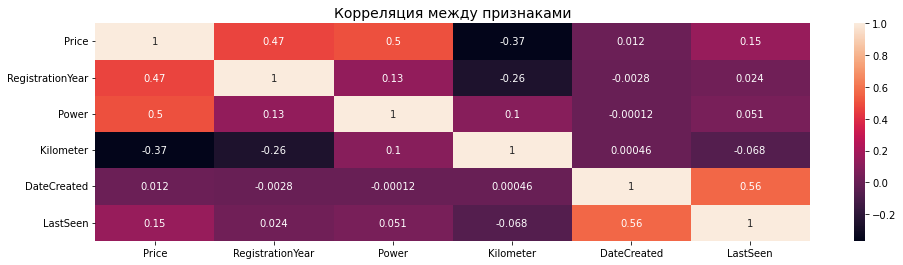

In [51]:
# построим 
plt.figure(figsize = (16,4))
plt.title('Корреляция между признаками', size=14)
sns.heatmap(data.corr(), annot = True);

Есть незначительная отрицательная корреляция между пробегом и ценой, а так же ценой и годом егистрации, что в полне объяснимо.

#### Промежуточный вывод

- Удалены признаки которые не оказывают влияние на целевой признак: 'DateCrawled','RegistrationMonth','NumberOfPictures','PostalCode';
- Удаленый дубликаты;
- Обработаны и заполнены пропуски, там где не удалось заполнить данные были удалены;
- Обработаны и удалены аномалии
- Столбцы с данными передены в тип int64 и выражены в дате.
- Общее удаление данных составило 10% от общего объема данных.

### Подготовка выборок для обучения

Предворительно приведем кодировку столбцов 'Model' и 'Brand' объеденив их значениев одном столбце и приведем их к численному значению. КОМЕНТАРИЙ СТЕДЕНТА: пробовал их оставить как есть и использовать как категориальные признаки. Линейная регрессия обучается очень долго 4-5 мин., остальные модели не смог дождаться результата. Думаю, все очень счильно заисит от скорости работы Юпитера, рано утром все работает нормально,к обеду время выполнения у величивается в десятки раз.

In [52]:
data_coded = data

In [53]:
data_coded['BrandModel'] = data_coded['Brand'].astype(str) + ' ' + data_coded['Model'].astype(str)
data_coded['ModelNew']   = data_coded['BrandModel'].map(data_coded.groupby('BrandModel').size()) / \
                           data_coded['Brand'].map(data_coded.groupby('Brand').size())
data_coded = data_coded.drop(['BrandModel', 'Brand', 'Model'], axis=1)
data = data.drop(['BrandModel', 'ModelNew'], axis=1)

In [54]:
#check
display(data.head())
display(data_coded.head())

,Price,VehicleType,RegistrationYear,Gearbox,Power,Model,Kilometer,FuelType,Brand,Repaired,DateCreated,LastSeen
0,480,sedan,1993,manual,101,golf,150000,petrol,volkswagen,unknown,745,759
2,9800,suv,2004,auto,163,grand,125000,gasoline,jeep,unknown,735,757
3,1500,small,2001,manual,75,golf,150000,petrol,volkswagen,no,738,738
4,3600,small,2008,manual,69,fabia,90000,gasoline,skoda,no,752,758
5,650,sedan,1995,manual,102,3er,150000,petrol,bmw,yes,756,758


,Price,VehicleType,RegistrationYear,Gearbox,Power,Kilometer,FuelType,Repaired,DateCreated,LastSeen,ModelNew
0,480,sedan,1993,manual,101,150000,petrol,unknown,745,759,0.392629
2,9800,suv,2004,auto,163,125000,gasoline,unknown,735,757,0.372964
3,1500,small,2001,manual,75,150000,petrol,no,738,738,0.392629
4,3600,small,2008,manual,69,90000,gasoline,no,752,758,0.387818
5,650,sedan,1995,manual,102,150000,petrol,yes,756,758,0.561361


Выделим целвой признак и разделим данные на выборки

In [55]:
# Преобразовуем категориальные признаки техникой OHE
data_ohe = pd.get_dummies(data_coded, drop_first=True)
# целевой признак 'Price'
target_coded = data_ohe['Price']
features_coded = data_ohe.drop('Price', axis=1)
# делим выборку на обучающую, валидайионную и тестовую
features_train, features_test, target_train, target_test = train_test_split(
    features_coded, target_coded, test_size=0.25, random_state=12345)

#стандартизируем численные признаки
numeric = ['RegistrationYear',  'Power', 'Kilometer', 'DateCreated', 'LastSeen', 'ModelNew']

scaler = StandardScaler()
scaler.fit(features_train[numeric])
# сохраним преобразованные обучающую и валидационную выборки в переменных
features_train[numeric] = scaler.transform(features_train[numeric])
features_test[numeric] = scaler.transform(features_test[numeric])

pd.options.mode.chained_assignment = None

#check
print(features_coded.shape)

(314013, 22)


In [56]:
#check
print('Обучающая выборка')
display(features_train.head(10))
print()
print('Тестовая выборка')
display(features_test.head(10))

Обучающая выборка


,RegistrationYear,Power,Kilometer,DateCreated,LastSeen,ModelNew,VehicleType_convertible,VehicleType_coupe,VehicleType_other,VehicleType_sedan,...,VehicleType_wagon,Gearbox_manual,FuelType_electric,FuelType_gasoline,FuelType_hybrid,FuelType_lpg,FuelType_other,FuelType_petrol,Repaired_unknown,Repaired_yes
94226,0.040334,0.521440,0.582645,0.989634,0.700381,-0.737604,0,0,0,1,...,0,1,0,0,0,0,0,1,1,0
179931,0.040334,2.051713,-1.574112,-1.478750,0.700381,0.435620,1,0,0,0,...,0,1,0,0,0,0,0,1,0,0
132217,0.794130,-0.971049,-0.091342,-0.083576,0.918197,-0.708334,0,0,0,0,...,0,1,0,0,0,0,0,1,1,0
151551,0.643370,-0.460958,-0.765328,1.311597,0.918197,0.341298,0,0,0,1,...,0,1,0,0,0,0,0,1,1,0
242322,-0.261184,-0.838803,0.582645,1.418918,0.700381,0.247375,0,0,0,1,...,0,1,0,1,0,0,0,0,0,0
188424,-1.165739,1.031531,0.582645,1.096955,0.809289,0.641692,0,0,0,1,...,0,1,0,0,0,0,0,1,1,0
133718,-0.261184,0.823716,0.582645,0.774992,0.700381,-1.334154,0,1,0,0,...,0,1,0,0,0,0,0,1,0,0
106382,-0.713461,-0.838803,0.582645,-1.586071,-1.368875,0.861830,0,0,0,1,...,0,1,0,0,0,0,0,1,0,0
214682,0.643370,3.544202,0.582645,-1.693392,-2.566866,-1.373730,0,0,0,0,...,0,0,0,1,0,0,0,0,1,0
308683,-0.864221,-0.366497,0.582645,0.989634,0.264748,-0.737604,0,0,0,0,...,1,1,0,0,0,0,0,1,0,0



Тестовая выборка


,RegistrationYear,Power,Kilometer,DateCreated,LastSeen,ModelNew,VehicleType_convertible,VehicleType_coupe,VehicleType_other,VehicleType_sedan,...,VehicleType_wagon,Gearbox_manual,FuelType_electric,FuelType_gasoline,FuelType_hybrid,FuelType_lpg,FuelType_other,FuelType_petrol,Repaired_unknown,Repaired_yes
325447,0.944889,1.730545,-2.922086,-1.156787,0.700381,0.641692,0,0,0,0,...,1,1,0,1,0,0,0,0,0,0
310561,0.794130,0.181379,0.582645,1.418918,0.809289,-0.980761,0,0,0,0,...,0,1,0,0,0,0,0,1,0,0
260544,-1.014980,-0.838803,-0.765328,-0.727503,-0.824334,-0.405189,0,0,0,1,...,0,1,0,0,0,0,0,1,0,0
110343,1.246407,0.389194,0.582645,0.131066,0.809289,-1.322033,0,0,0,0,...,0,0,0,1,0,0,0,0,0,0
120124,0.191093,0.313625,-0.091342,1.526239,0.809289,1.354205,1,0,0,0,...,0,1,0,0,0,0,0,1,0,0
228581,0.191093,-0.272035,0.582645,0.667671,0.918197,-0.995957,0,0,0,0,...,0,1,0,1,0,0,0,0,0,0
292479,0.794130,-0.630988,-0.091342,1.633560,0.700381,0.834409,0,0,0,0,...,0,1,0,0,0,0,0,1,0,0
198284,0.944889,0.049133,-2.382896,1.418918,0.809289,-0.793156,0,0,0,1,...,0,1,0,0,0,0,0,1,0,0
205165,0.794130,-0.952157,-0.765328,-1.049466,0.155840,-1.258930,1,0,0,0,...,0,1,0,1,0,0,0,0,1,0
69328,0.643370,2.032821,-0.765328,-0.942145,0.918197,-1.359210,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0


## Обучение моделей

Создаим констатную модель.

In [57]:
predction_base = pd.Series(data=target_coded.mean(), index=target_coded.index, dtype='int64')
rmse_base = mean_squared_error(target_coded, predction_base) ** 0.5
print("RMSE для константной модели:", round(rmse_base, 2))

RMSE для константной модели: 4559.22


### Линейная регрессия

In [58]:
%%time
model_linear_regression = LinearRegression()
mse_linear_regression = cross_val_score(
    model_linear_regression,
    features_train,
    target_train,
    cv=5,
    scoring='neg_mean_squared_error')

CPU times: user 4.49 s, sys: 309 ms, total: 4.79 s
Wall time: 905 ms


In [59]:
print("RMSE для линейной модели на обучающей выборке:", round((-mse_linear_regression.mean()) ** 0.5, 2))

RMSE для линейной модели на обучающей выборке: 2879.83


Обучим модель

In [60]:
%%time
model_linear_regression.fit(features_train, target_train)

CPU times: user 473 ms, sys: 45.2 ms, total: 518 ms
Wall time: 157 ms


LinearRegression()

Получим предсказание модели

In [61]:
%%time
prediction_linear_regression = model_linear_regression.predict(features_train)

CPU times: user 38.2 ms, sys: 5.06 ms, total: 43.3 ms
Wall time: 16 ms


### Модель Лассо

In [62]:
%%time
alphas = np.arange(0.1, 1, 0.4)
for alpha in alphas :
    model_lasso = Lasso(alpha = alpha)
    mse_lasso = cross_val_score(
        model_lasso,
        features_train,
        target_train,
        cv=5,
        scoring='neg_mean_squared_error')
    print("RMSE для Lasso alpha={:.2f} модели на обучающей выборке: {:.2f}".format(alpha, (-mse_lasso.mean()) ** 0.5))

RMSE для Lasso alpha=0.10 модели на обучающей выборке: 2879.77
RMSE для Lasso alpha=0.50 модели на обучающей выборке: 2879.80
RMSE для Lasso alpha=0.90 модели на обучающей выборке: 2879.97
CPU times: user 1min 10s, sys: 1.18 s, total: 1min 12s
Wall time: 12.2 s


Обучим модель

In [63]:
%%time
model_lasso = Lasso(alpha=0.1)
model_lasso.fit(features_train, target_train)

CPU times: user 5.31 s, sys: 87.4 ms, total: 5.4 s
Wall time: 905 ms


Lasso(alpha=0.1)

Получим предсказание модели

In [64]:
%%time
prediction_lasso = model_lasso.predict(features_test)

CPU times: user 20 ms, sys: 9.34 ms, total: 29.4 ms
Wall time: 18.2 ms


### Модель LightGBM

Подготоим данные для модели LightGBM.

In [65]:
display(data.head(3))

,Price,VehicleType,RegistrationYear,Gearbox,Power,Model,Kilometer,FuelType,Brand,Repaired,DateCreated,LastSeen
0,480,sedan,1993,manual,101,golf,150000,petrol,volkswagen,unknown,745,759
2,9800,suv,2004,auto,163,grand,125000,gasoline,jeep,unknown,735,757
3,1500,small,2001,manual,75,golf,150000,petrol,volkswagen,no,738,738


Выделим целевой признак.

In [66]:
target_gbm = data['Price']
features_gbm = data.drop('Price', axis=1)

In [67]:
#check
print(target_gbm.shape)
print(features_gbm.shape)
display(features_gbm.head())

(314013,)
(314013, 11)


,VehicleType,RegistrationYear,Gearbox,Power,Model,Kilometer,FuelType,Brand,Repaired,DateCreated,LastSeen
0,sedan,1993,manual,101,golf,150000,petrol,volkswagen,unknown,745,759
2,suv,2004,auto,163,grand,125000,gasoline,jeep,unknown,735,757
3,small,2001,manual,75,golf,150000,petrol,volkswagen,no,738,738
4,small,2008,manual,69,fabia,90000,gasoline,skoda,no,752,758
5,sedan,1995,manual,102,3er,150000,petrol,bmw,yes,756,758


In [68]:
for c in features_gbm.columns:
    col_type = features_gbm[c].dtype
    if col_type == 'object' or col_type.name == 'category':
        features_gbm[c] = features_gbm[c].astype('category')

In [69]:
features_gbm.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 314013 entries, 0 to 354368
Data columns (total 11 columns):
 #   Column            Non-Null Count   Dtype   
---  ------            --------------   -----   
 0   VehicleType       314013 non-null  category
 1   RegistrationYear  314013 non-null  int64   
 2   Gearbox           314013 non-null  category
 3   Power             314013 non-null  int64   
 4   Model             314013 non-null  category
 5   Kilometer         314013 non-null  int64   
 6   FuelType          314013 non-null  category
 7   Brand             314013 non-null  category
 8   Repaired          314013 non-null  category
 9   DateCreated       314013 non-null  int64   
 10  LastSeen          314013 non-null  int64   
dtypes: category(6), int64(5)
memory usage: 16.5 MB


Разделим выборку на тренирочную и тестовую.

In [70]:
X_train, X_test, y_train, y_test = train_test_split(features_gbm, target_gbm, test_size=0.20, random_state=314)

In [71]:
#check
print(X_train.shape)
print(X_test.shape)
print(y_train.shape)
print(y_test.shape)

(251210, 11)
(62803, 11)
(251210,)
(62803,)


In [72]:
%%time
estimator_new = lgb.LGBMRegressor(num_leaves=31)

param_grid_new = {'learning_rate': [0.2, 0.4, 0.6],
                  'max_depth': [15, 20, 25]}

gbm_new = GridSearchCV(
    estimator_new,
    param_grid_new,
    cv=3,
    n_jobs = -1,
    verbose = 0,
    scoring = 'neg_mean_squared_error'
)

gbm_new.fit(X_train, y_train)

[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
CPU times: user 10.9 s, sys: 1.19 s, total: 12.1 s
Wall time: 15.5 s


GridSearchCV(cv=3, estimator=LGBMRegressor(), n_jobs=-1,
             param_grid={'learning_rate': [0.2, 0.4, 0.6],
                         'max_depth': [15, 20, 25]},
             scoring='neg_mean_squared_error')

In [73]:
print(gbm_new.best_params_)

{'learning_rate': 0.2, 'max_depth': 15}


In [74]:
print("RMSE для LightGBM модели на обучающей выборке:",round((-gbm_new.best_score_) ** 0.5, 2))

RMSE для LightGBM модели на обучающей выборке: 1579.56


Обучим модель

In [75]:
%%time
model_lgbm = lgb.LGBMRegressor(num_leaves=31, learning_rate=0.2, max_depth=20)
model_lgbm.fit(X_train, y_train)

CPU times: user 4.3 s, sys: 116 ms, total: 4.41 s
Wall time: 467 ms


LGBMRegressor(learning_rate=0.2, max_depth=20)

Получим предсказание модели

In [76]:
%%time
prediction_lgbm = model_lgbm.predict(X_train)

CPU times: user 2.23 s, sys: 49.9 ms, total: 2.28 s
Wall time: 257 ms


## Анализ моделей

1. Скорость обучения модели:
    - LinearRegression: 0.37 сек., 
    - Lasso: 6 сек.,
    - LightGBT: 5 сек. 
2. Скорость  получения предсказания:
    - LinearRegression 0.01 сек.,
    - Lasso: 0.1 сек.,
    - LightGBT: 2 сек.
3. RMSE:
    - LinearRegression 2879, 
    - Lasso: 2879,
    - LightGBT: 1580.
4. Вывод:
    - Модель линейной регрессии оакзалась самой быстрой и с наименшей точностью.
    - Модель LightGBM показала наилучшую точность, но и время обучения превышает линейную модель.

## Выбор модели и проверка ее на тестововй выборке

Наилучший резальтат показал модель LightGBM. Проверим ее на тестовой выборке

In [77]:
prediction_lgbm = model_lgbm.predict(X_test)

In [78]:
mse_lgbm = mean_squared_error(y_test, prediction_lgbm)
print("RMSE для линейной модели на тестовой выборке:", round((mse_lgbm) ** 0.5, 2))

RMSE для линейной модели на тестовой выборке: 1560.8


## Общий вывод

В ходе выполнения данной работы были выполнены следующие задачи и получены соответсвующие результаты:
1. Были загружены и изучены данные;
2. Произведена предобработка данных:
    - были заполнены пропуски, удалены дубликаты. Общая потеря данных 8,2% от общего числа;
    - были удалены признаки, которые не оказывают влияние на будущую модель, а именно: 'DateCrawled', 'RegistrationMonth', 'NumberOfPictures', 'PostalCode';
    - На основе двух категоральных признаков 'Model' и 'Brand' был создан числовой признак 'ModelNew'. Данное решение существенно сократило время обучения моделей;
3. Данные были разделены на выборки, станартизированы.
4. Были исследованы 3 модели:  LinearRegression, Lasso, LightGBT;
5. Призведен анализ времени "работы" каждой модели;
    - наиболее быстрой  сточки зрения обучения и получения предсказаний оказалась модель LinearRegression;
    - наилучшей по качеству предсказаний оказадась модель LightGBT;
9. Модель LightGBT была выбрана как лучшая и опробована на тестовой выборке с результатом RMSE=1558.